# Fit exponentials to Cell 5 from Kylie PROTOCOL 5

All the data files are in my OneDrive at: /OneDrive .../Postdoc/cardiacNoiseData, but I'll add some of the data here in folder Some_Kilies_data/
There is a readme.txt file explaining what is in each file, including the names of the protocols and a dictionary of cell's names.  Protocols 3-5 are big files to have in github. Protocl 7 is the sine wave data, and protocol 6 is the action potential data. I'll start with one of the smaller data sets.

The protocols that I have the myokit version are 2, 3, 4, 5

To do:
- load data
- epsilon
- leak current
- minimize residuals

In [1]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import myokit
import myokit.lib.markov
#from scipy.interpolate import interp1d,  UnivariateSpline, splrep, splev, make_lsq_spline, BSpline
from scipy.optimize import minimize, minimize_scalar#, curve_fit
import cma
from sklearn.linear_model import LinearRegression

In [2]:
def SRexpo_spline(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    
    residuals = expo_splines - data
    return sum(residuals**2)

def SRexpo_spline_weight(params, times, deltat, data, expo_4):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    #weight = np.exp(-(times-deltat)) / sum(np.exp(-(times-deltat)))
    weight =  1 / (1 + 9 * ((times - deltat)>10) + 90 * ((times - deltat)>100) +  900 * ((times - deltat)>1000))
    residuals = (expo_splines - data) 
    return sum((residuals**2) * weight)

def expo_spline(times, deltat, params, expo_4):
    # three_expo = flag to calculate 2 or 3 exponentials. Default == False. If true, we'll be fitting sum of 3 expo
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    if expo_4:
        expo_splines = expo_splines + params[5]*np.exp(-(times-deltat)/params[6]) + params[7]*np.exp(-(times-deltat)/params[8])
    return expo_splines

def Quadratic_fit_for_N(N, x, data):
    quadratic_fit = x * (1 - x / N) 
    residuals = quadratic_fit - data
    return sum(residuals**2)

## Meta parameters

All the jump voltages have a time at the beggining that we will remove. We'll remove 50ms 
times_to_skip = 50 

Flag to decide if the spline fit has been saved or not (saved_splines)

Use of 4 exponentials: NumExpo_flag = True ; or 3 exponentials NumExpo_flag = False

In [23]:
times_to_skip = 50 
NumExpo_flag = True # We will use 4 exponentials
saved_splines = False
# DEfine the file names with and without weights 
FileNameSplines = 'protocol5_cell5_splines_params_largerCurrents.npy' 
FileNameSplinesWeights = 'protocol5_cell5_splines_params_largerCurrents_weights.npy' 
if saved_splines:
    print('This code will load the splines parameters instead of fitting them')
else:
    print('This code will fit the splines parameters')

This code will fit the splines parameters


## Focus on one protocol first

Start with protocol 3, cell 5

To do:
- divide wrt constant V intervals
- investigate the spline interpolation
- get splines per interval
- get residuals
- ploy residuals vs 1. Current, 2. Voltage, 3. time

## Separate by V level

The current and time is partitinonated to a level of V

In [4]:
# Load the data
pr5_time, pr5_voltage, pr5_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR5cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)

# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_5 = myokit.load_protocol('resources/pr5-deactivation.mmt')


# Define the steps of the protocol
pr5_Vtimes = (np.array(protocol_5.log_for_interval(0,pr5_time[-1] + 0.1)['time'])*10)
pr5_Vtimes = pr5_Vtimes.astype(np.int32)

pr5_current_constV = {}
pr5_current_constV_without_first5ms = {}
pr5_time_constV_without_first5ms = {}
for i in range(len(pr5_Vtimes)-1):
    pr5_current_constV[i]= pr5_current[pr5_Vtimes[i]:(pr5_Vtimes[i+1]-1)]
    pr5_current_constV_without_first5ms[i] = pr5_current[pr5_Vtimes[i]+times_to_skip:(pr5_Vtimes[i+1]-1)]
    pr5_time_constV_without_first5ms[i] = pr5_time[pr5_Vtimes[i]+times_to_skip:(pr5_Vtimes[i+1]-1)]
print(len(pr5_current_constV))


54


## Define color scheme by V's

There are 9 unique V's. (-120, -80:20:60), So I need 9 unique colors. 

In [6]:
# Voltages
pr5_voltage_constV = pr5_voltage[pr5_Vtimes[:-1]]

pr5_unique_Vs, pr5_unique_Vs_1stUindex, pr5_unique_Vs_index= np.unique(pr5_voltage_constV, return_index = True, return_inverse = True)
print(pr5_unique_Vs)
# Colors & labels long
pr5_unique_Vs_colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd']
#pr3_unique_Vs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
pr5_voltage_constV_colors = []
pr5_voltage_constV_labels_full = []
for i in range(len(pr5_unique_Vs_index)):
    pr5_voltage_constV_colors.append(pr5_unique_Vs_colors[pr5_unique_Vs_index[i]])
    pr5_voltage_constV_labels_full.append('V ='+str(pr5_unique_Vs[pr5_unique_Vs_index[i]]))

# Labels simple
pr5_voltage_constV_labels_simple = np.repeat('_nolegend_', len(pr5_unique_Vs_index))
for i in range(len(pr5_unique_Vs_1stUindex)):
    pr5_voltage_constV_labels_simple[pr5_unique_Vs_1stUindex[i]] = 'V ='+str(pr5_unique_Vs[i])


[-120. -110. -100.  -90.  -80.  -70.  -60.  -50.  -40.   50.]


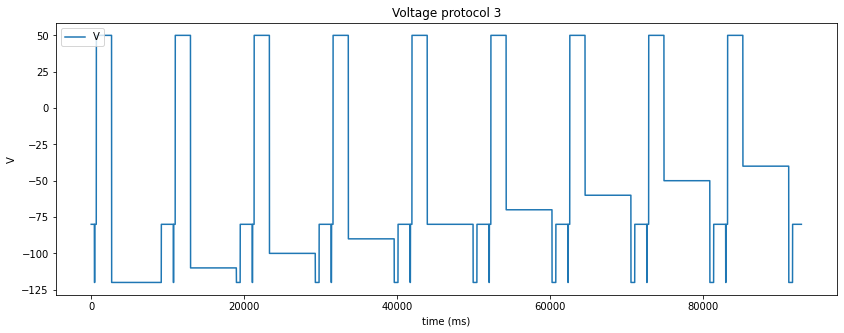

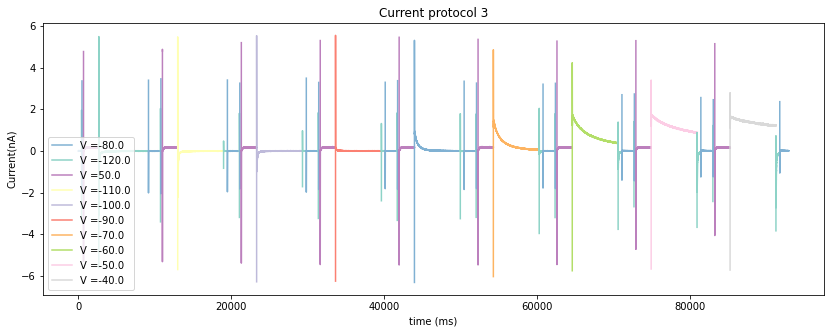

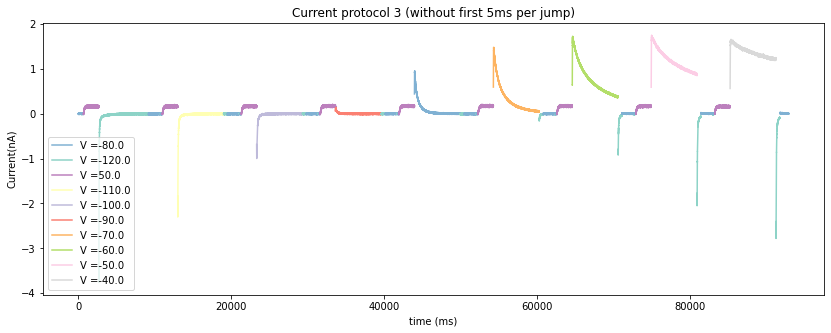

In [7]:
plt.figure(figsize=(14, 5))
plt.plot(pr5_time, pr5_voltage,'-', label='V')
plt.xlabel('time (ms)')
plt.ylabel('V')
plt.title('Voltage protocol 3')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(14, 5))
for i in range(len(pr5_Vtimes)-1):
    plt.plot(pr5_time[pr5_Vtimes[i]:(pr5_Vtimes[i+1]-1)], pr5_current_constV[i],'-', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
#plt.ylim([-.1,.1])
#plt.xlim([0,2000])
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3')
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(14, 5))
#plt.plot(pr5_time,pr5_current,':', label = 'Full current')
for i in range(len(pr5_Vtimes)-1):
    plt.plot(pr5_time_constV_without_first5ms[i], pr5_current_constV_without_first5ms[i],'-', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3 (without first 5ms per jump)')
plt.legend(loc='lower left')
plt.show()



## Estimate epsilon from V = -80

- load data for V=-80
- take residuals ? 
    - does it makes sense or is it directly take values since the mean current is zero?
- Get R^2 by batch and mean
- Get the mean of the R^2

20


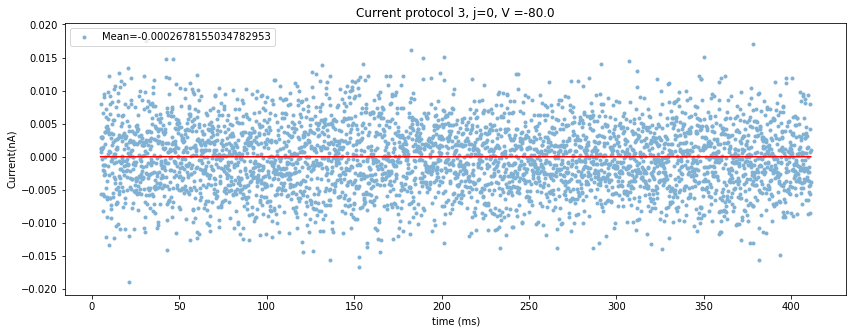

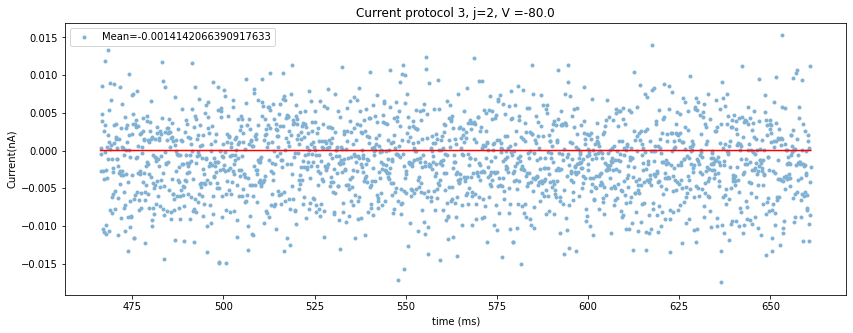

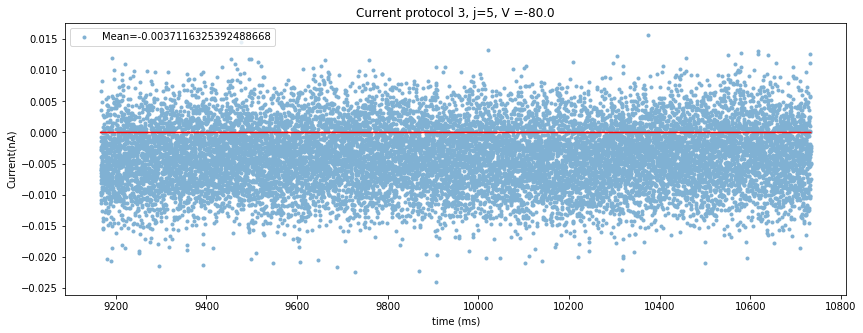

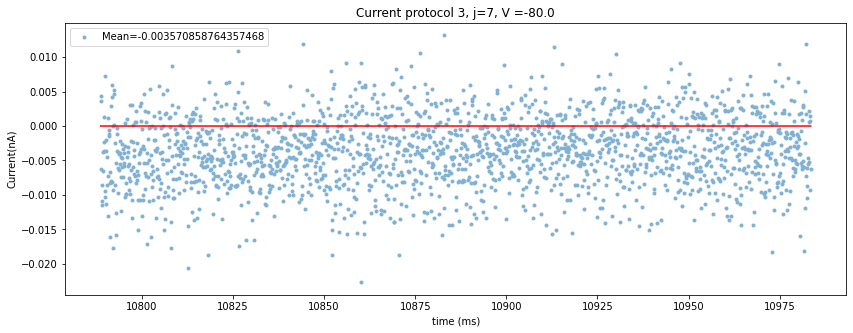

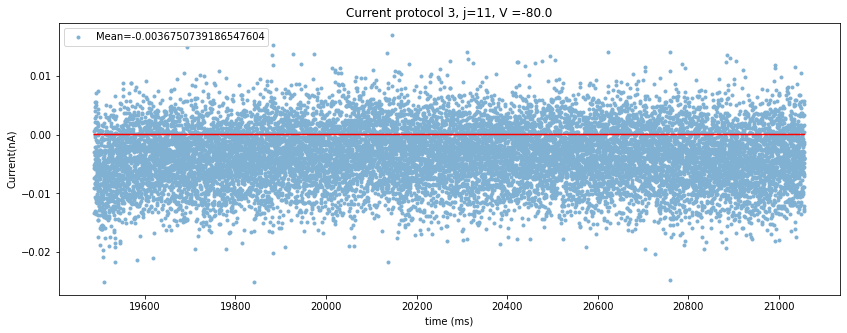

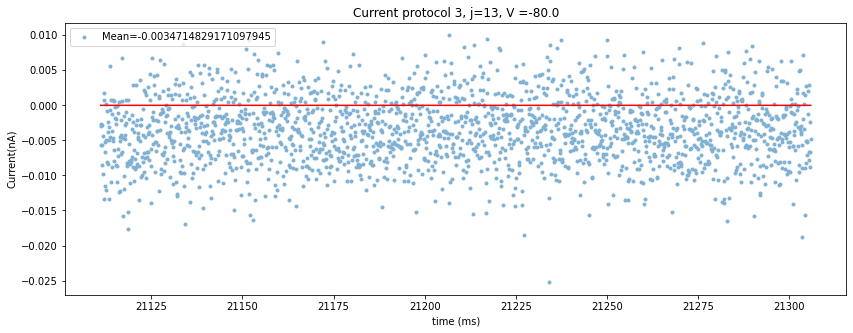

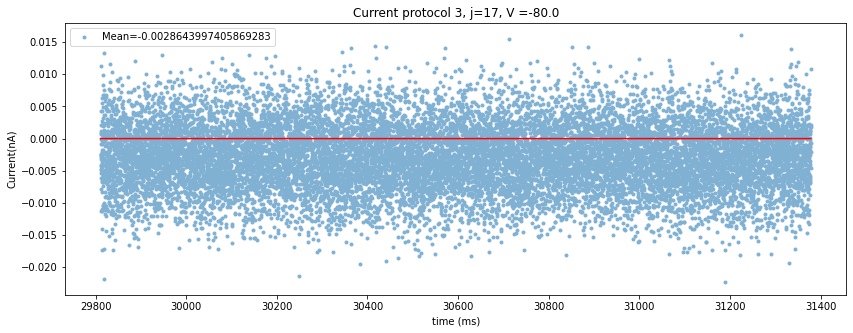

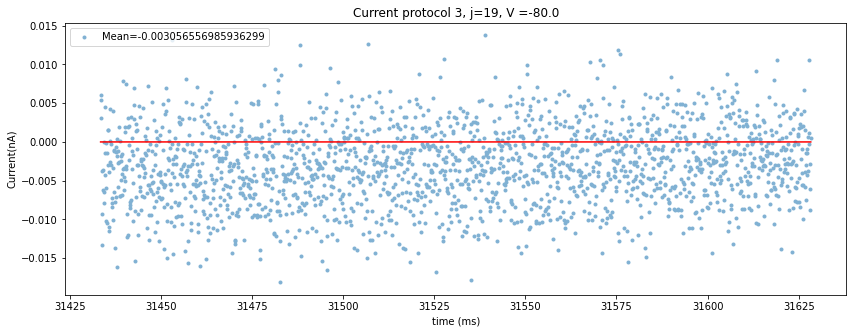

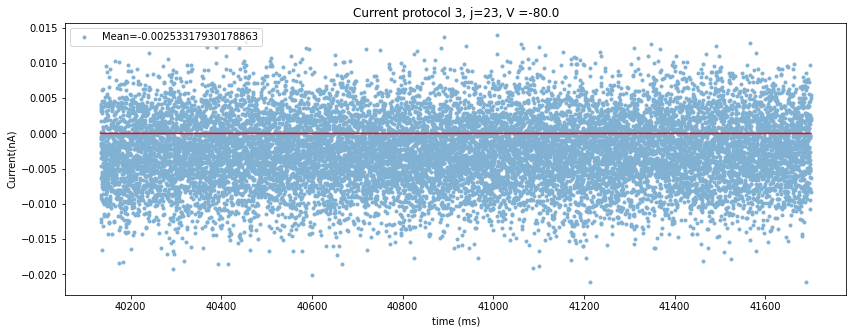

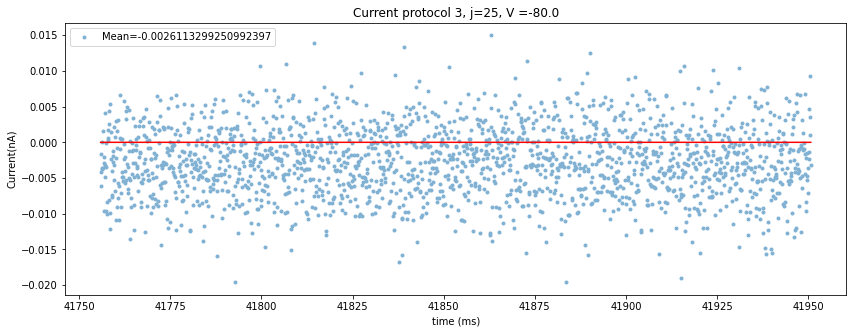

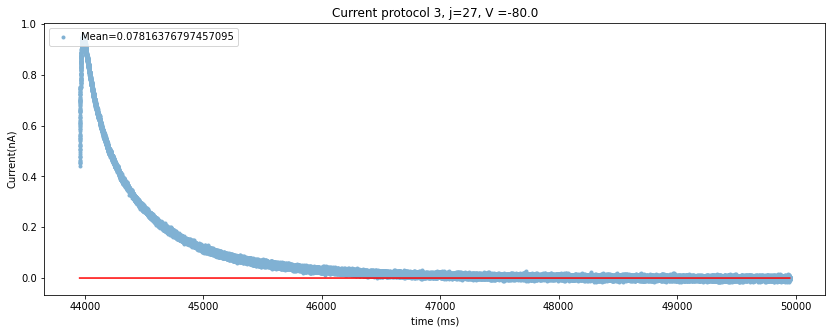

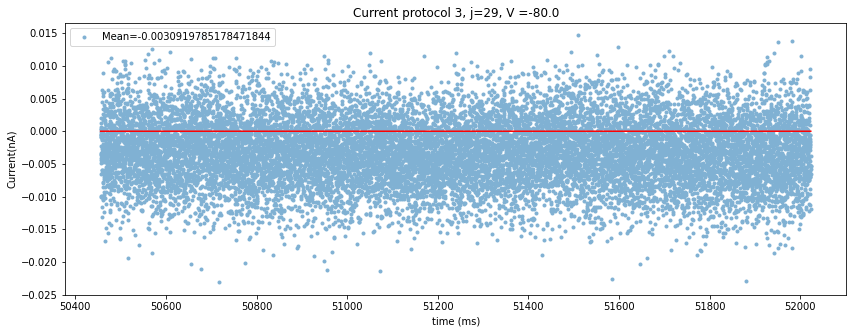

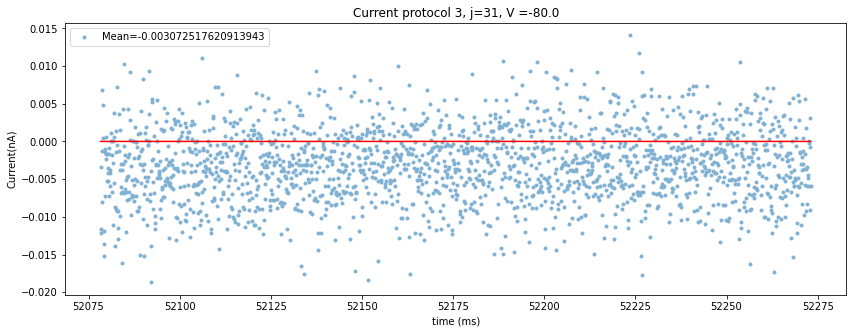

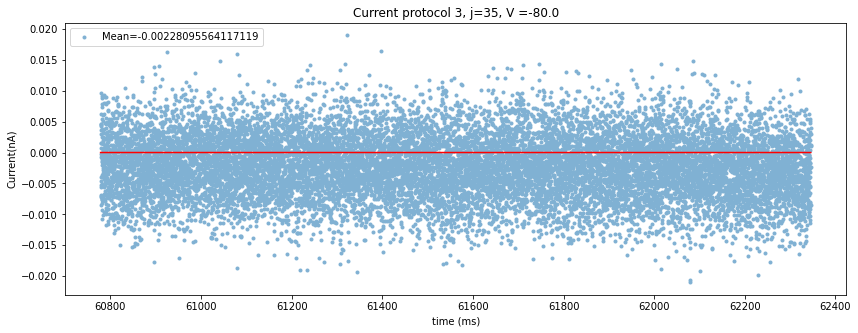

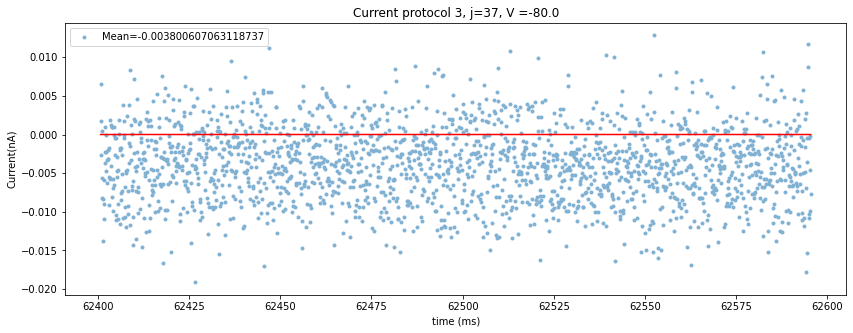

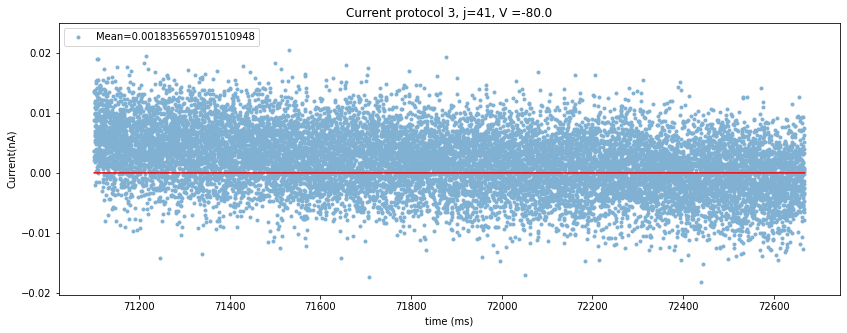

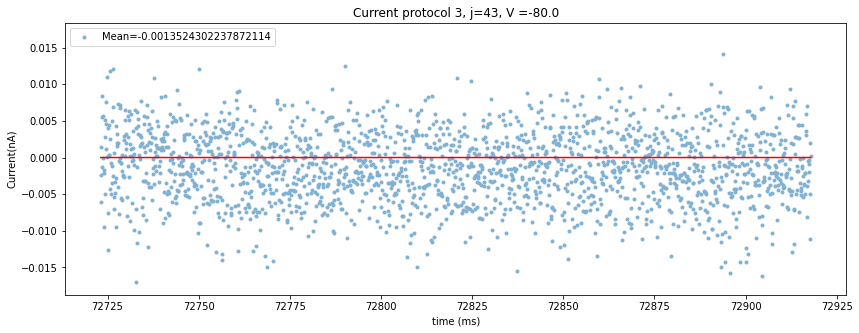

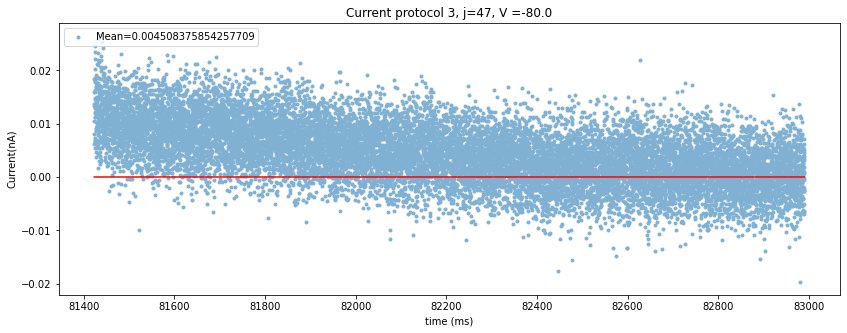

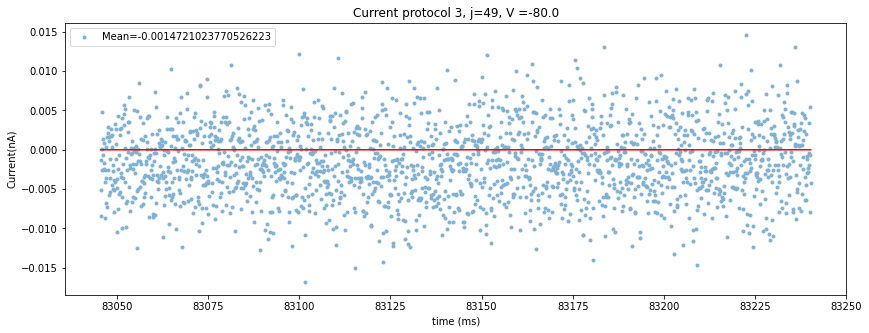

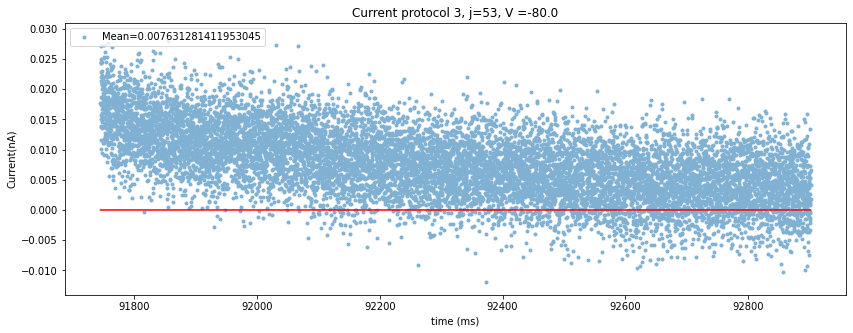

In [8]:
# Find where V = -80
print(sum(pr5_voltage_constV==-80))
pr5_index_neg80 = np.nonzero(pr5_voltage_constV==-80)
pr5_index_neg80 = pr5_index_neg80[0]
pr5_index_neg80_meanzero = []
pr5_V80_means = np.zeros(len(pr5_index_neg80))
pr5_V80_vars = np.zeros(len(pr5_index_neg80))

#pr5_current_constV_all80s =np.array([])
pr5_current_constV_80smeanzero =np.array([])

for k in range(len(pr5_index_neg80)):
    j = pr5_index_neg80[k]
    pr5_V80_means[k] = np.mean(pr5_current_constV_without_first5ms[j])
    pr5_V80_vars[k] = np.var(pr5_current_constV_without_first5ms[j])
    #pr5_current_constV_all80s = np.append(pr5_current_constV_all80s, pr5_current_constV[j][times_to_skip:])
    if np.abs(pr5_V80_means[k]) < 0.001:
        pr5_index_neg80_meanzero.append(j)
        pr5_current_constV_80smeanzero =np.append(pr5_current_constV_80smeanzero, pr5_current_constV_without_first5ms[j])
    plt.figure(figsize=(14, 5))
    plt.plot(pr5_time_constV_without_first5ms[j], pr5_current_constV_without_first5ms[j],'.', color = pr5_voltage_constV_colors[j], label='Mean='+str(np.mean(pr5_current_constV_without_first5ms[j])))
    plt.plot(pr5_time_constV_without_first5ms[j],np.zeros(len(pr5_time_constV_without_first5ms[j])), color = 'r')
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, j=' + str(j) + ', '+ pr5_voltage_constV_labels_full[j])
    plt.legend(loc='upper left')
    
plt.show()


In [9]:
#print(V80_means)
#print(V80_vars)
print('---- ALL V=-80 -------- V=-80 AND |mean|<0.009---')
print('Mean of means by jump:')
print([np.mean(pr5_V80_means), np.mean(pr5_V80_means[np.abs(pr5_V80_means)<0.009])])
print('Mean of all the time steps together for mean<0.009:')
print([0, np.mean(pr5_current_constV_80smeanzero)])


print('Mean of Vars per jump:')
#print(V80_vars[np.abs(V80_means)<0.009])
epsilonA = np.mean(pr5_V80_vars)
epsilonB = np.mean(pr5_V80_vars[np.abs(pr5_V80_means)<0.001])
print([epsilonA, epsilonB])


print('Var of the time steps together: for mean<0.009:')
epsilon1 = np.var(pr5_current_constV_80smeanzero)
print([0, epsilon1])



---- ALL V=-80 -------- V=-80 AND |mean|<0.009---
Mean of means by jump:
[0.002494597863152486, -0.0014879900374484855]
Mean of all the time steps together for mean<0.009:
[0, -0.0002678155034782953]
Mean of Vars per jump:
[0.0013484652364164841, 2.6134161549220416e-05]
Var of the time steps together: for mean<0.009:
[0, 2.6134161549220416e-05]


# Leak current

I'll check the transition between V=-80 to V=-120 to check if the leak current has been removed from the data set. 

For protocol 5, we always have the sequence of Vs:  -120, -80, -120, -80, 50. And I'm interested in the -80,-120, -80 part. 

[ 0  2  5  7 11 13 17 19 23 25 27 29 31 35 37 41 43 47 49]
[ 0  5 11 17 23 27 29 35 41 47]


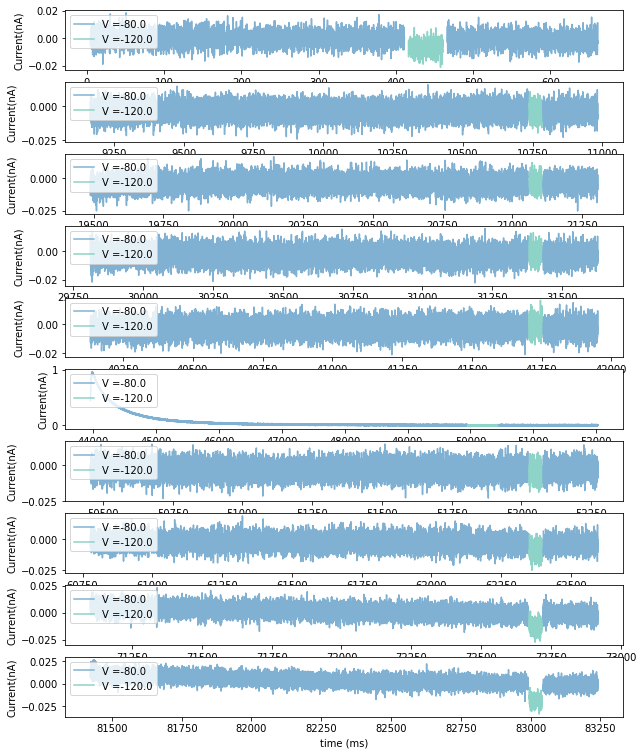

In [10]:
pr5_index_leak80 = np.nonzero(pr5_voltage_constV[:-2]==-80)
pr5_index_leak80 = pr5_index_leak80[0]
pr5_index_leak120 = np.nonzero(pr5_voltage_constV[pr5_index_leak80+1]==-120)
pr5_index_leak120 = pr5_index_leak120[0]
print(pr5_index_leak80)
print(pr5_index_leak80[pr5_index_leak120])

pr5_index_leak = pr5_index_leak80[pr5_index_leak120] # Index for the -80 to start the -80,-120,-80 jump. 


fig, axs = plt.subplots(len(pr5_index_leak),1, figsize=(10, 13))
axs = axs.ravel()

for k in range(len(pr5_index_leak)):
    j = pr5_index_leak[k]
    
    axs[k].plot(pr5_time_constV_without_first5ms[j], pr5_current_constV_without_first5ms[j], color = pr5_voltage_constV_colors[j], label=pr5_voltage_constV_labels_full[j])
    axs[k].plot(pr5_time_constV_without_first5ms[j+1], pr5_current_constV_without_first5ms[j+1], color = pr5_voltage_constV_colors[j+1], label=pr5_voltage_constV_labels_full[j+1])
    axs[k].plot(pr5_time_constV_without_first5ms[j+2], pr5_current_constV_without_first5ms[j+2], color = pr5_voltage_constV_colors[j+2], label='_nolegend_')
    axs[k].set_ylabel('Current(nA)')
    axs[k].legend(loc='upper left')
axs[k].set_xlabel('time (ms)')

plt.show()

## Voltage larger or equal than ??

Need to decide what is the voltage level for this protocol

For the moment I'll use everything above -80, but I think i should be using every one of them. Similar for protocol 3


In [15]:
pr5_largecurrent_lowerV = -79
print(pr5_voltage_constV[:-1]>=pr5_largecurrent_lowerV)

pr5_index_largerCurrents = np.nonzero(pr5_voltage_constV[:-1]>=pr5_largecurrent_lowerV)

pr5_index_largerCurrents = pr5_index_largerCurrents[0]
print(len(pr5_index_largerCurrents))

splines_largerCurrents = [None] * len(pr5_index_largerCurrents)
splines_params_largerCurrents = [None] * len(pr5_index_largerCurrents)
residuals2_largerCurrents = [None] * len(pr5_index_largerCurrents)
times_largerCurrents = [None] * len(pr5_index_largerCurrents)
currents_largerCurrents = [None] * len(pr5_index_largerCurrents)
deltat_largerCurrents = np.zeros(len(pr5_index_largerCurrents))


splines_largerCurrents_weights = [None] * len(pr5_index_largerCurrents)
splines_params_largerCurrents_weights= [None] * len(pr5_index_largerCurrents)
residuals2_largerCurrents_weights = [None] * len(pr5_index_largerCurrents)

# Separate times and currents:

for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i]
    times_largerCurrents[index_i] = pr5_time_constV_without_first5ms[i]
    currents_largerCurrents[index_i] = pr5_current_constV_without_first5ms[i]
    deltat_largerCurrents[index_i] =  times_largerCurrents[index_i][0]


[False False False  True False False False False  True False False False
 False False  True False False False False False  True False False False
 False False  True False False False False False  True  True False False
 False False  True  True False False False False  True  True False False
 False False  True  True False]
13


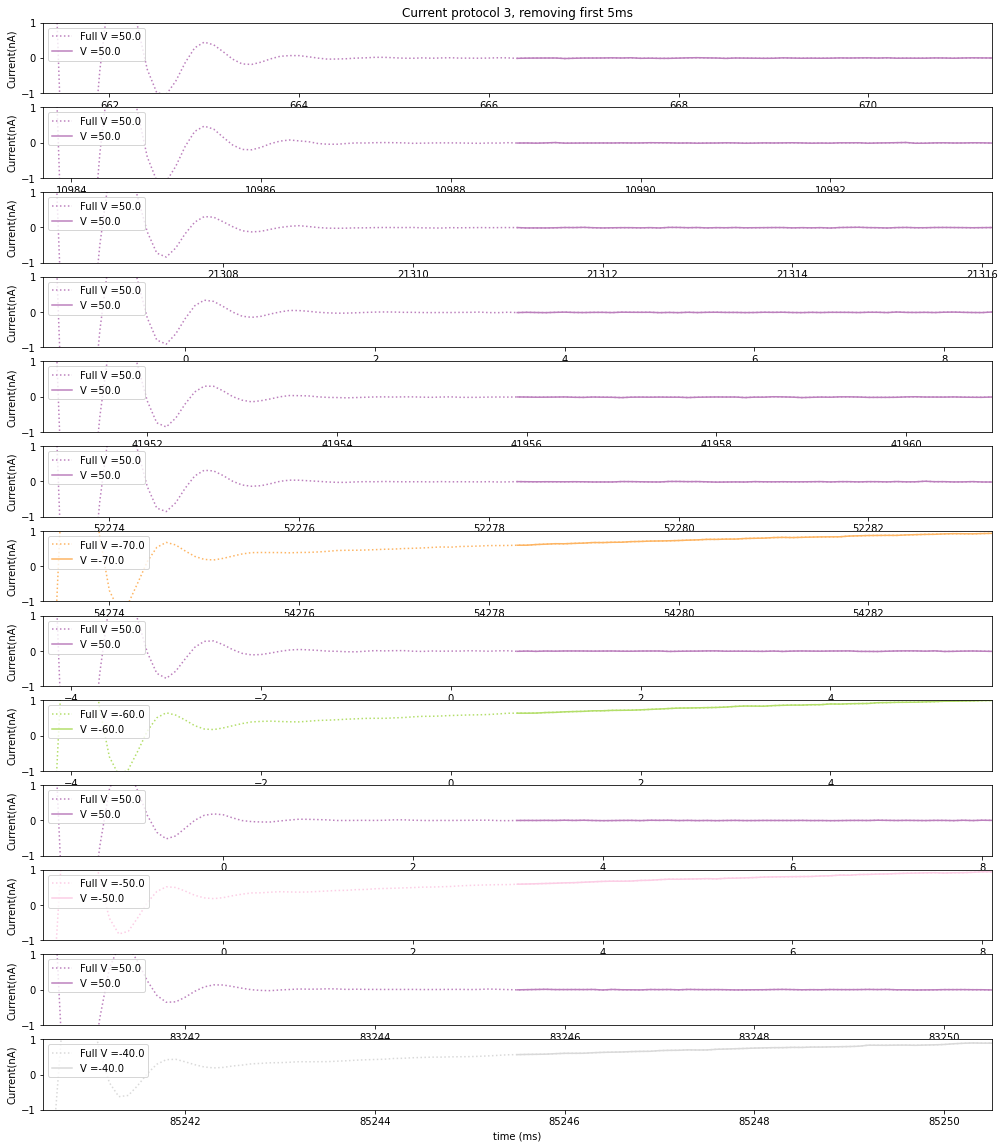

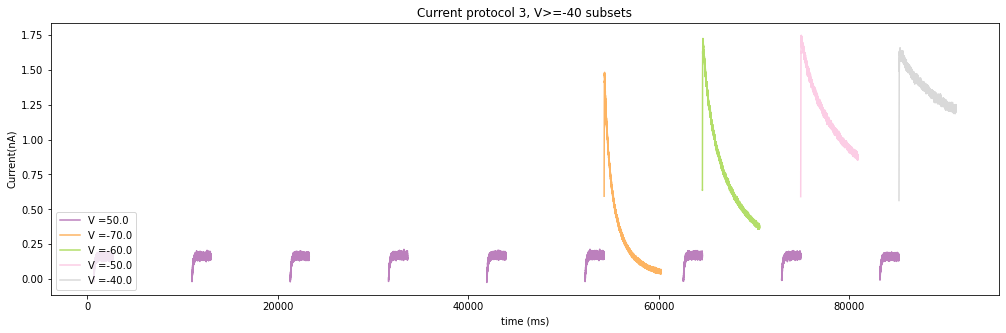

In [16]:

fig, axs = plt.subplots(len(pr5_index_largerCurrents),1, figsize=(17, 20))
axs = axs.ravel()
for index_i in range(len(pr5_index_largerCurrents)): 
    i=pr5_index_largerCurrents[index_i]
    axs[index_i].plot(pr5_time[(pr5_Vtimes[i]):(pr5_Vtimes[i+1]-1)], pr5_current_constV[i],':',color = pr5_voltage_constV_colors[i], label='Full ' + pr5_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-',color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_full[i])
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylim([-1,1])
    axs[index_i].set_xlim([pr5_time[pr5_Vtimes[i]],pr5_time[pr5_Vtimes[i]]+10])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, removing first 5ms')
axs[index_i].set_xlabel('time (ms)')
plt.show()



plt.figure(figsize=(17, 5))
#plt.plot(pr5_time, pr5_current,':', label='Full protocol')
for index_i in range(len(pr5_index_largerCurrents)): 
    i=pr5_index_largerCurrents[index_i]
    plt.plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-',color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, V>=-40 subsets')
    plt.legend(loc='lower left')
plt.show()


In [24]:
# Find or load the splines parameters. NO WEIGHTS
if saved_splines:
    # Load the parameters of the spline:
    splines_params_largerCurrents = np.load(FileNameSplines)
    for index_i in range(len(pr5_index_largerCurrents)): 
        splines_largerCurrents[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents[index_i], NumExpo_flag)
    print('Loading DONE')
else:
    # CMA fit, NO weights. If paramerers had been save, skip this cell
    for index_i in range(len(pr5_index_largerCurrents)): 
        i=pr5_index_largerCurrents[index_i]
        #Inital conditions and constrains:
        if NumExpo_flag:
            p0 = [currents_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
            bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
        else:
            p0 = [splines_largerCurrents[index_i][-1],splines_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
            bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]
        optscma = cma.CMAOptions()
        optscma.set("bounds", bounds_cma)
        # CMA fit
        es = cma.fmin(SRexpo_spline, p0 , sigma0=1, args=[times_largerCurrents[index_i], deltat_largerCurrents[index_i], currents_largerCurrents[index_i], NumExpo_flag], options = optscma)
        splines_params_largerCurrents[index_i] = es[0]
        splines_largerCurrents[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents[index_i], NumExpo_flag)
    # SAve the parameters of the spline:
    np.save(FileNameSplines,np.array(splines_params_largerCurrents))
    print('Fitting DONE')



(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=697510, Thu Oct  7 15:52:15 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 9.450875101434951e+02 1.0e+00 8.82e-01  8e-01  9e-01 0:00.0
    2     20 1.076754309923057e+03 1.1e+00 7.88e-01  8e-01  8e-01 0:00.1
    3     30 7.258540327172279e+02 1.2e+00 6.94e-01  6e-01  7e-01 0:00.1
  100   1000 5.536533068166946e+00 1.2e+02 1.40e-01  3e-02  2e-01 0:02.4
  200   2000 2.417207081157128e+00 5.8e+03 3.38e-01  2e-02  3e+00 0:05.0
  300   3000 1.828255938806806e+00 2.8e+04 1.88e-02  2e-04  2e-01 0:08.0
  400   4000 1.826213492132774e+00 5.5e+04 1.78e-01  5e-04  1e+00 0:10.7
  500   5000 1.823321338501793e+00 1.3e+05 3.87e-01  5e-04  2e+00 0:13.3
NOTE (module=cma, iteration=581):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 8.0e+10 to 4.3e+07
  600   6000 1.823147504995457e+00 9.9e+03 1.20e-01  4e-05  8e-01 0:15.7
  700   7000 1.823119678629891e

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1298)
  warnings.warn(msg + ' (' +


 1400  14000 1.900301291756387e+00 8.9e+01 4.20e+01  9e+00  3e+02 0:33.2
 1413  14130 1.900296219076387e+00 1.3e+02 1.27e+02  2e+01  1e+03 0:33.5
termination on tolfacupx=1000.0 (Thu Oct  7 16:12:31 2021)
final/bestever f-value = 1.900297e+00 1.900296e+00
incumbent solution: [ 1.21265494e-01 -2.31914603e-01  3.63646396e+03  2.76494219e-01
  4.38282562e+03 -2.05458754e-02  2.33031841e+02 -1.60547415e-01 ...]
std deviations: [ 417.60754362  357.45263723  395.07295302  454.64757323  416.42110499
  537.77638168   23.75486191 1078.14667692 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=693474, Thu Oct  7 16:12:31 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.321780879855313e+03 1.0e+00 8.66e-01  8e-01  9e-01 0:00.0
    2     20 7.771403712316624e+01 1.1e+00 8.00e-01  8e-01  8e-01 0:00.1
    3     30 2.256562459306992e+03 1.2e+00 7.48e-01  7e-01  8e-01 0:00.1
  100   1000 5.679660875855034e+00 8.0e+01 1.06e-01  2e-02  2e-01 0:02.4

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1071)
  warnings.warn(msg + ' (' +


 1100  11000 1.857932378184879e+00 3.4e+00 6.10e+00  4e+00  8e+00 0:25.5
 1200  12000 1.857901367312428e+00 4.7e+01 1.17e+01  4e+00  2e+01 0:27.8
 1300  13000 1.857859647556060e+00 1.9e+02 2.58e+01  5e+00  6e+01 0:30.1
 1400  14000 1.857815542798548e+00 6.4e+02 5.54e+01  7e+00  9e+01 0:32.4
 1500  15000 1.857784769163048e+00 2.1e+03 8.21e+01  1e+01  2e+02 0:34.7
 1600  16000 1.857747151672935e+00 4.5e+03 1.39e+02  7e+00  2e+02 0:37.0
 1700  17000 1.857726065766113e+00 9.5e+03 4.35e+02  8e+00  5e+02 0:39.4
 1800  18000 1.857706406899907e+00 1.1e+04 2.74e+02  3e+00  2e+02 0:41.8
 1900  19000 1.857695534424163e+00 1.9e+04 5.08e+02  2e+00  3e+02 0:44.4
 2000  20000 1.857687717279147e+00 3.1e+04 1.48e+03  5e+00  5e+02 0:46.8
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 2100  21000 1.857682251772010e+00 6.5e+04 1.78e+03  5e+00  5e+02 0:49.3
 2124  21240 1.857681469390407e+00 6.5e+04 4.53e+03  1e+01  1e+03 0:49.9
termination on tolfacupx=1000.0 (Thu Oct  7 16:15:07

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=576)
  warnings.warn(msg + ' (' +


  600   6000 1.865784453417638e+00 4.4e+00 5.53e-03  4e-03  1e-02 0:13.7
  700   7000 1.865784389702777e+00 8.4e+01 3.16e-02  2e-02  1e-01 0:16.0
  800   8000 1.865784295583397e+00 4.0e+02 8.97e-02  4e-02  3e-01 0:18.3
  900   9000 1.865784185362871e+00 1.3e+03 2.32e-01  4e-02  1e+00 0:20.6
 1000  10000 1.865784060607051e+00 1.4e+03 2.69e-01  2e-02  7e-01 0:22.9
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.865783952305376e+00 2.0e+03 7.26e-01  8e-02  1e+00 0:25.2
 1200  12000 1.865783835117269e+00 1.8e+04 1.72e+00  2e-01  5e+00 0:27.5
 1300  13000 1.865783731529242e+00 4.0e+04 5.06e+00  3e-01  7e+00 0:29.8
 1400  14000 1.865783616379491e+00 1.1e+05 5.02e+00  2e-01  5e+00 0:32.1
 1500  15000 1.865783487494450e+00 2.9e+05 1.24e+01  4e-01  1e+01 0:34.4
 1600  16000 1.865783312363543e+00 6.3e+05 4.02e+01  8e-01  2e+01 0:36.8
 1700  17000 1.865783083775592e+00 1.5e+06 1.26e+02  2e+00  5e+01 0:39.1
 1800  18000 1.865782814842739e+00 3.3e+06 1.53e+02 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1395)
  warnings.warn(msg + ' (' +


 1400  14000 1.996741800837838e+00 1.5e+00 1.94e+01  2e+01  2e+01 0:32.2
 1500  15000 1.996725969071887e+00 6.4e+01 7.19e+01  2e+01  3e+02 0:34.5
 1600  16000 1.996721998976505e+00 4.2e+02 1.76e+02  3e+01  7e+02 0:36.8
 1641  16410 1.996721045687688e+00 8.4e+02 2.38e+02  3e+01  1e+03 0:37.8
termination on tolfacupx=1000.0 (Thu Oct  7 16:24:02 2021)
final/bestever f-value = 1.996721e+00 1.996721e+00
incumbent solution: [ 7.62454016e-02  1.78094289e+02  8.87683133e+03 -1.77994698e+02
  8.87306921e+03 -1.30986553e-01  1.45904668e+02 -6.43229198e-02 ...]
std deviations: [ 476.69677163  265.28791051  682.56939488 1021.77800487  925.40041717
  592.74870702  216.8041783    25.91833386 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=756116, Thu Oct  7 16:24:02 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 8.807777566620825e+03 1.0e+00 9.38e-01  9e-01  1e+00 0:00.1
    2     20 6.460106868128159e+03 1.2e+00 8.10e-01  8e-01  8e-01 0:00.1

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1505)
  warnings.warn(msg + ' (' +


 1600  16000 1.793040700764659e+00 4.0e+01 1.12e+02  5e+01  3e+02 0:37.2
 1636  16360 1.793038837791012e+00 8.7e+01 3.06e+02  1e+02  1e+03 0:38.0
termination on tolfacupx=1000.0 (Thu Oct  7 16:28:57 2021)
final/bestever f-value = 1.793039e+00 1.793039e+00
incumbent solution: [ 6.06748596e-02  2.07776605e+00  8.15707833e+03 -1.96745251e+00
  7.69644418e+03 -1.54972170e-01  1.28838416e+02 -3.38090090e-02 ...]
std deviations: [ 902.5588818   712.69913947  606.9592743   624.84353818 1061.10077755
  257.47204723  134.53967925  155.66471523 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=738389, Thu Oct  7 16:28:57 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.902428718001814e+04 1.0e+00 8.89e-01  9e-01  9e-01 0:00.1
    2     20 1.712358330970292e+04 1.1e+00 8.99e-01  8e-01  9e-01 0:00.1
    3     30 1.162339620733033e+04 1.3e+00 8.30e-01  8e-01  8e-01 0:00.2
   51    510 1.147801681712421e+02 1.4e+01 1.25e-01  6e-02  2e-01 0:03.2

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=749)
  warnings.warn(msg + ' (' +


  800   8000 1.795770625101183e+00 9.8e+00 6.00e-01  4e-01  8e-01 0:21.7
  900   9000 1.795757478681425e+00 7.4e+01 1.04e+00  5e-01  2e+00 0:24.4
 1000  10000 1.795745457344612e+00 2.8e+02 1.21e+00  3e-01  2e+00 0:27.1
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.795736740801773e+00 1.1e+03 4.24e+00  6e-01  5e+00 0:29.8
 1200  12000 1.795728877439343e+00 3.4e+03 1.31e+01  2e+00  2e+01 0:32.3
 1300  13000 1.795720140102581e+00 1.5e+04 2.53e+01  2e+00  7e+01 0:35.0
 1400  14000 1.795709169319972e+00 3.0e+04 3.53e+01  2e+00  9e+01 0:37.8
 1500  15000 1.795702379610605e+00 5.8e+04 6.31e+01  1e+00  1e+02 0:40.6
 1600  16000 1.795694905981772e+00 1.1e+05 1.53e+02  2e+00  2e+02 0:43.4
 1700  17000 1.795689477961756e+00 2.0e+05 2.71e+02  1e+00  3e+02 0:46.2
 1800  18000 1.795686627444368e+00 3.2e+05 3.53e+02  8e-01  3e+02 0:49.0
 1900  19000 1.795684191770143e+00 6.0e+05 5.94e+02  7e-01  3e+02 0:51.8
 1972  19720 1.795681992351324e+00 8.7e+05 2.55e+03 

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=681)
  warnings.warn(msg + ' (' +


  700   7000 6.185815704861647e+00 2.2e+00 8.15e-02  6e-02  9e-02 0:52.4
  800   8000 6.185791279936089e+00 1.8e+01 4.12e-01  1e-01  7e-01 1:00.4
  900   9000 6.185635719338331e+00 2.5e+02 2.83e+00  5e-01  1e+01 1:08.1
 1000  10000 6.185259072352586e+00 1.0e+03 4.08e+00  6e-01  2e+01 1:15.8
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 6.184853322418979e+00 2.5e+03 1.32e+01  1e+00  3e+01 1:23.8
 1200  12000 6.184591341137468e+00 5.6e+03 1.35e+01  1e+00  2e+01 1:31.6
 1300  13000 6.184452010563540e+00 1.2e+04 2.59e+01  1e+00  2e+01 1:39.4
 1400  14000 6.184382115121518e+00 1.9e+04 4.48e+01  9e-01  3e+01 1:47.4
 1500  15000 6.184355088523174e+00 3.8e+04 5.01e+01  6e-01  3e+01 1:55.1
 1600  16000 6.184346290818060e+00 5.3e+04 5.09e+01  3e-01  2e+01 2:03.3
 1700  17000 6.184345531512772e+00 1.2e+05 4.97e+00  2e-02  1e+00 2:11.7
 1760  17600 6.184345531385998e+00 1.7e+05 3.23e-01  1e-03  6e-02 2:16.7
termination on tolfun=1e-11 (Thu Oct  7 16:40:10 202

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=831)
  warnings.warn(msg + ' (' +


  900   9000 1.635467514140489e+00 2.3e+01 2.49e+00  2e+00  6e+00 0:25.3
 1000  10000 1.634982690534314e+00 1.4e+02 5.29e+00  3e+00  1e+01 0:28.2
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  11000 1.633655944589608e+00 1.6e+03 1.94e+01  1e+01  6e+01 0:30.9
 1200  12000 1.632770528113966e+00 7.2e+03 1.72e+01  1e+01  7e+01 0:33.7
 1300  13000 1.632736025709098e+00 1.8e+04 6.27e+00  4e+00  1e+01 0:36.7
 1387  13870 1.632686098170588e+00 2.2e+05 9.52e+01  1e+02  1e+03 0:38.9
termination on tolfacupx=1000.0 (Thu Oct  7 16:41:48 2021)
final/bestever f-value = 1.632685e+00 1.632685e+00
incumbent solution: [ 1.08992284e-01  3.77560002e+02  3.62733377e+03 -3.77507499e+02
  3.62675541e+03 -9.83321652e-02  1.42166496e+02 -7.28911103e-02 ...]
std deviations: [1038.9795723   583.72441944   98.20628679  925.16202095  888.57994152
  643.80910128  716.88515459  125.12792802 ...]
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=711656, Thu Oct  7 16:41:48 2021)

/Users/pmzah/.pyenv/versions/3.8.5/lib/python3.8/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1059)
  warnings.warn(msg + ' (' +


 1100  11000 8.854189461618372e+00 9.4e+00 9.28e+00  5e+00  2e+01 1:24.6
 1200  12000 8.848234806837636e+00 3.4e+01 9.26e+01  3e+01  3e+02 1:32.2
 1300  13000 8.837427141454615e+00 1.1e+02 8.14e+01  1e+01  2e+02 1:39.8
 1400  14000 8.830345488233769e+00 2.2e+02 1.38e+02  1e+01  3e+02 1:47.8
 1500  15000 8.826627813388056e+00 4.3e+02 3.47e+02  2e+01  5e+02 1:55.5
 1522  15220 8.825710227174646e+00 5.8e+02 5.13e+02  2e+01  1e+03 1:57.3
termination on tolfacupx=1000.0 (Thu Oct  7 16:44:54 2021)
final/bestever f-value = 8.825642e+00 8.825642e+00
incumbent solution: [ 1.08730666e+00  7.50222316e+01  2.49855279e+03 -7.47266230e+01
  2.48384748e+03  2.59073344e-01  1.11210490e+03 -1.08011891e+00 ...]
std deviations: [ 299.27556862  245.44845825   80.20924393 1011.56444057   52.5931638
  439.51404825   19.49492251   24.97827041 ...]
Fitting DONE


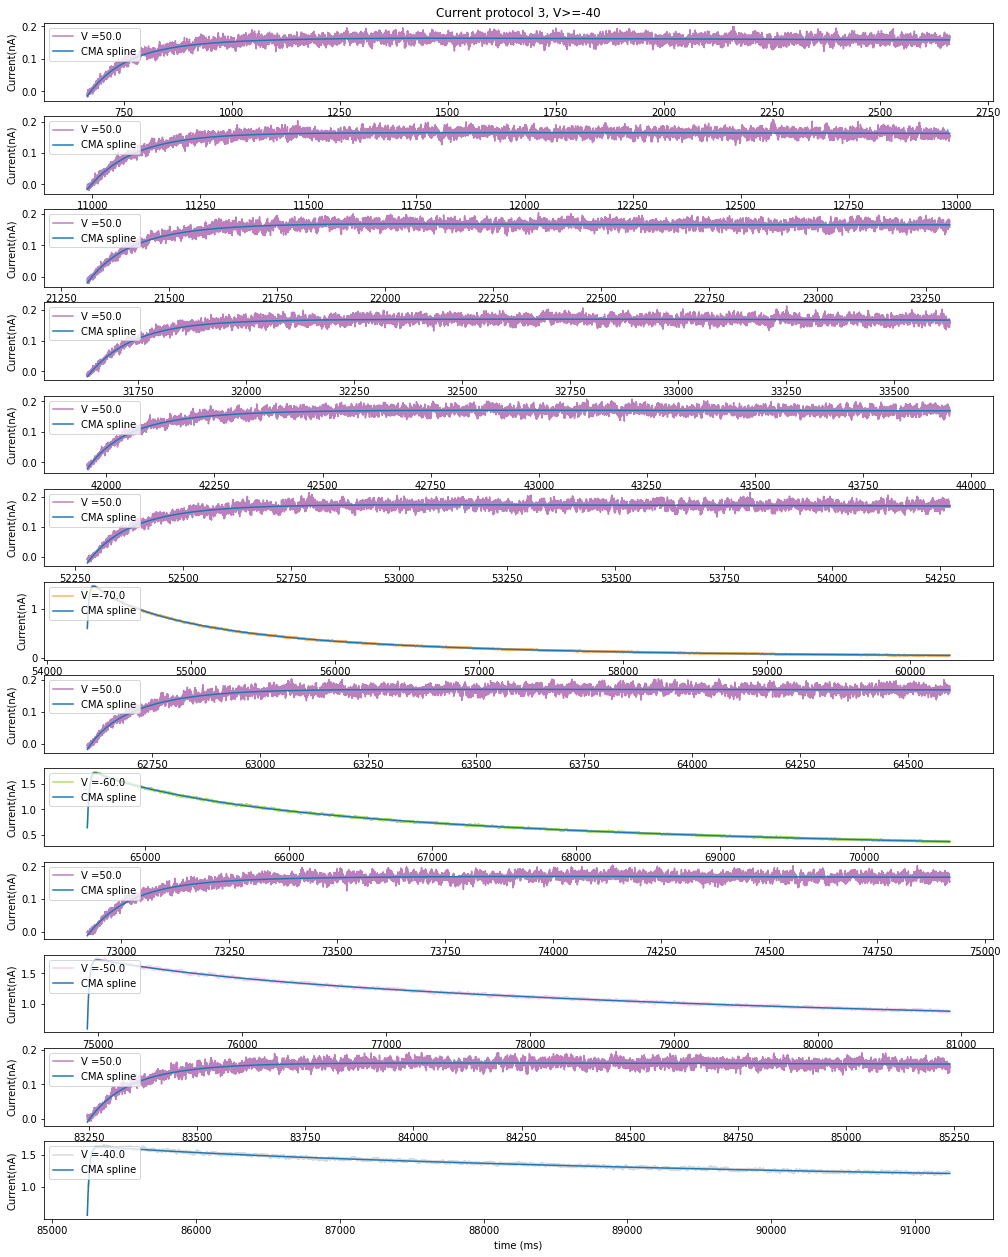

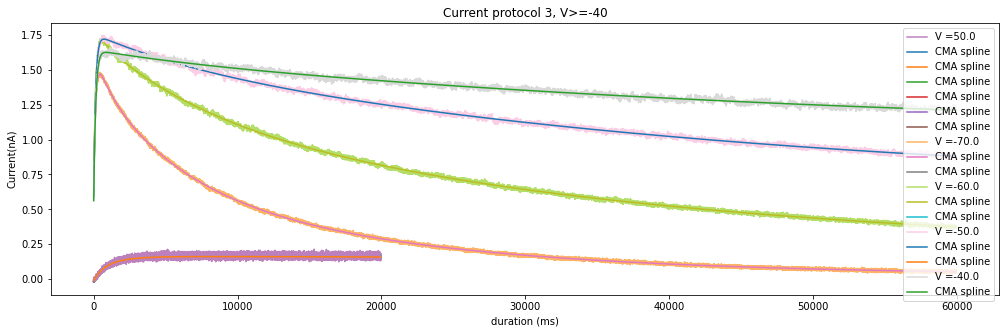

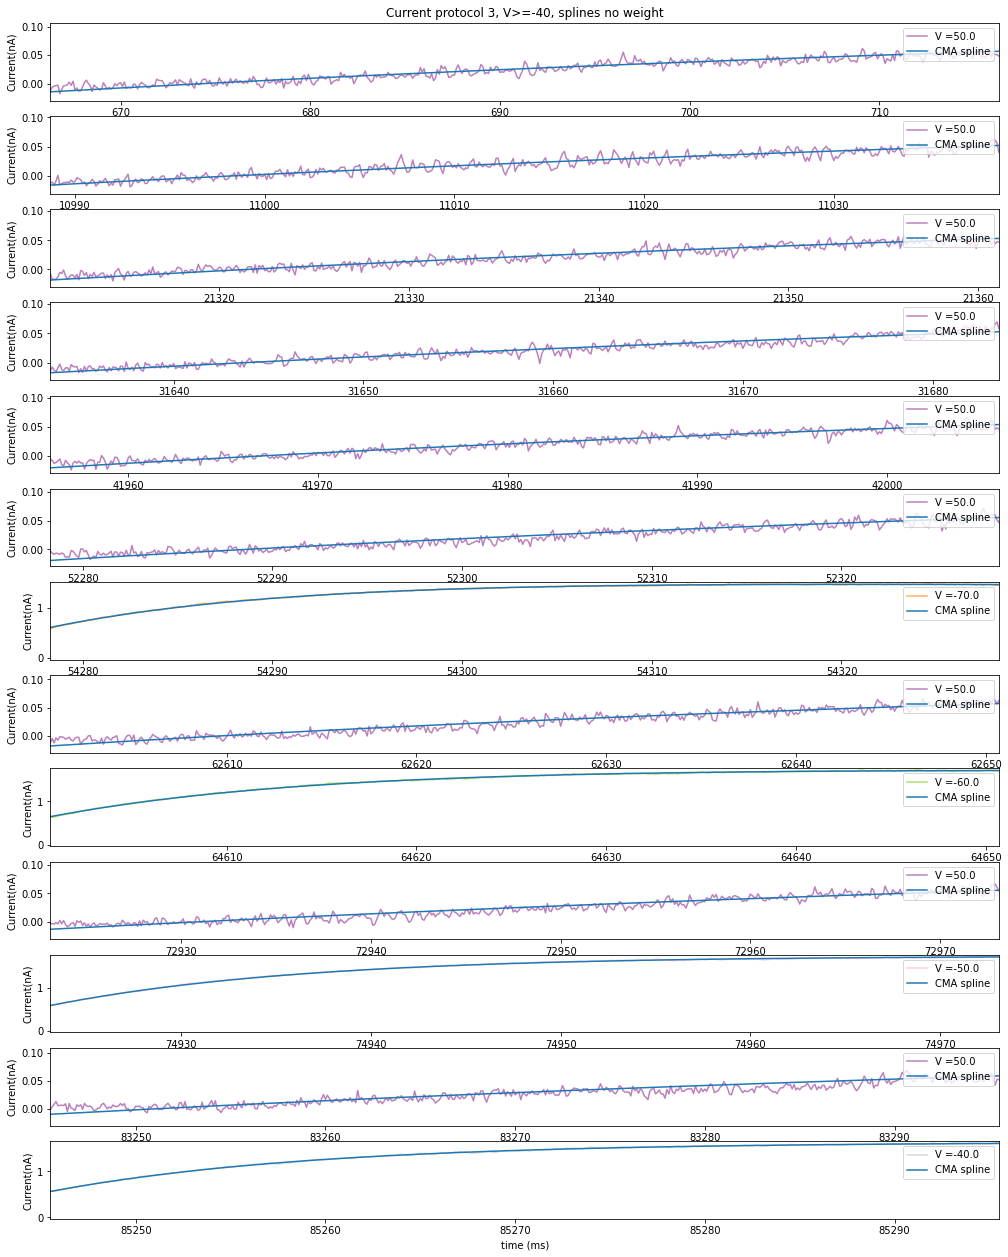

In [25]:
# Trying a better plot
fig, axs = plt.subplots(len(pr5_index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40')
plt.legend(loc='upper right')
plt.show()

# Zoom with no weights

fig, axs = plt.subplots(len(pr5_index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper right')
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].set_xlim([times_largerCurrents[index_i][0],times_largerCurrents[index_i][0]+50])
    axs[index_i].set_ylim([-.03, splines_largerCurrents[index_i][500] + 0.05])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, splines no weight')
axs[index_i].set_xlabel('time (ms)')
plt.show()

In [ ]:
# Find or load the splines parameters. WITH WEIGHTS
if saved_splines:
    # Load the parameters
    splines_params_largerCurrents_weights = np.load(FileNameSplinesWeights)
    for index_i in range(len(pr5_index_largerCurrents)): 
        splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents_weights[index_i], NumExpo_flag)
    print('Loading with weights DONE')
else:
    # CMA_fit with weighting residuals
    for index_i in range(len(pr5_index_largerCurrents)): 
        i=pr5_index_largerCurrents[index_i]
        #Inital conditions and constrains:
        if NumExpo_flag:
            p0 = [currents_largerCurrents[index_i][-1], 0.01,times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0], 0.01,(times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0]), 0.01, (times_largerCurrents[index_i][-1]-times_largerCurrents[index_i][0])/2, 0.1,1]
            bounds_cma = [[None, None, 0, None, 0, None, 0,None, 0], [None, None, None, None, None, None, None,None,None]]
        else:
            p0 = [splines_largerCurrents[index_i][-1],splines_largerCurrents[index_i][-1] ,times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0] ,0.01 , times_largerCurrents[index_i][-1] - times_largerCurrents[index_i][0]]
            bounds_cma = [[0, 0, 0, 0, 0], [None, None, None, None, None]]
        optscma = cma.CMAOptions()
        optscma.set("bounds", bounds_cma)
        # CMA fit
        es = cma.fmin(SRexpo_spline_weight, p0 , sigma0=1, args=[times_largerCurrents[index_i], deltat_largerCurrents[index_i], currents_largerCurrents[index_i], NumExpo_flag], options = optscma)
        splines_params_largerCurrents_weights[index_i] = es[0]
        splines_largerCurrents_weights[index_i] = expo_spline(times_largerCurrents[index_i], deltat_largerCurrents[index_i], splines_params_largerCurrents_weights[index_i], NumExpo_flag)
    # SAVE THE PARAMETERS
    np.save(FileNameSplinesWeights,np.array(splines_params_largerCurrents_weights))
    print('Fitting with weights DONE')


In [ ]:
fig, axs = plt.subplots(len(pr5_index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Current(nA)')
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, with weights')
axs[index_i].set_xlabel('time (ms)')
plt.show()


plt.figure(figsize=(10, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i],'-', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
    plt.plot(splines_largerCurrents_weights[index_i], label = 'CMA spline')
plt.xlabel('duration (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, V>=-40, with weigths')
plt.legend(loc='upper right')
plt.show()

# Zoom

fig, axs = plt.subplots(len(pr5_index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper right')
    axs[index_i].set_ylabel('Current(nA)')
    axs[index_i].set_xlim([times_largerCurrents[index_i][0]-2,times_largerCurrents[index_i][0]+50])
    axs[index_i].set_ylim([-.03, splines_largerCurrents_weights[index_i][500] + 0.05])
    if index_i == 0:
        axs[index_i].set_title('Current protocol 3, V>=-40, with weight')
axs[index_i].set_xlabel('time (ms)')
plt.show()

## Start analysis of the residuals (noise)

We will use the data with splines AND weights: "spline_..._weights"

In [ ]:
# Residuals

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    residuals = currents_largerCurrents[index_i] - splines_largerCurrents_weights[index_i]
    residuals2_largerCurrents_weights[index_i] = residuals ** 2
    plt.plot(times_largerCurrents[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Current protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], currents_largerCurrents[index_i],'-', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Current')
plt.title('Current protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Histograms of the residuasl
plt.figure(figsize=(17, 5))
plt.hist(residuals2_largerCurrents_weights, bins = 10, density =True, cumulative=True, color = np.array(pr5_voltage_constV_colors)[pr5_index_largerCurrents.astype(int)], label=pr5_voltage_constV_labels_simple[pr5_index_largerCurrents.astype(int)])
plt.legend(loc='upper right')
plt.xlabel('Residuals^2')
plt.ylabel('Frequency')
plt.title('Residuals^2 protocol 3')

plt.show()

In [ ]:
# Take Batch_size time steps and take mean of the residuals, and mean of the spline fit to get a nicer plot
batch_size  = 500
remove_at_end_weights = np.zeros(len(residuals2_largerCurrents_weights)).astype(int)
residuals2_largerCurrents_weights_meanbatch = [None] * len(pr5_index_largerCurrents)
times_largerCurrents_weights_meanbatch = [None] * len(pr5_index_largerCurrents)
splines_largerCurrents_weights_meanbatch = [None] * len(pr5_index_largerCurrents)
currents_largerCurrents_meanbatch = [None] * len(pr5_index_largerCurrents)

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    remove_at_end_weights[index_i] = len(residuals2_largerCurrents_weights[index_i])%batch_size
    residuals2_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(residuals2_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    splines_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(splines_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    times_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(times_largerCurrents[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    currents_largerCurrents_meanbatch[index_i] =np.mean(np.reshape(currents_largerCurrents[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    plt.plot(times_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2, protocol 3, V>=-40, with weights'+ ' batch size = ' + str(batch_size))
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
plt.hist(residuals2_largerCurrents_weights_meanbatch,  color = np.array(pr5_voltage_constV_colors)[pr5_index_largerCurrents.astype(int)], label=pr5_voltage_constV_labels_simple[pr5_index_largerCurrents.astype(int)])
plt.xlabel('Residuals^2 binned')
plt.xlabel('Frequency')
plt.title('Residuals^2 protocol 3, batch size = ' + str(batch_size))
plt.show()




## Scatter plots

Residuals vs: Voltage, Current, and opennes

In [ ]:

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot( residuals2_largerCurrents_weights[index_i], pr5_voltage_constV[i]*np.ones(len(residuals2_largerCurrents_weights[index_i])),'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.ylabel('Voltage')
plt.xlabel('Residuals^2')
plt.title('Residuals^2 vs V, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(residuals2_largerCurrents_weights_meanbatch[index_i], pr5_voltage_constV[i]*np.ones(len(residuals2_largerCurrents_weights_meanbatch[index_i])), '.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.ylabel('Voltage')
plt.xlabel('Residuals^2')
plt.title('Residuals^2 vs V, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()



plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 vs raw I, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('Current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 vs raw I, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 vs splines I, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('Current')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 vs splines I, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

## Individual currents (o micro currents)

For micro current:
- Micro current will refer to the indivudual channel current
    - We can get it using i(V) = (V- Ek)*gamma_i
- gamma_i (where gamma_micro is the conductance of an individual channel)
- So the total cell current is I(V) = i(V) * N * O, which is the one we get from the experiments


The parameters:
- Upper and lower bounds for N :  [10,000, 76,000]
- E_k = -85 (from experiments)
- gamma_i =  2e-6  (2 pS -> to uS)
- V depends on the time


In [ ]:
# Single channel parameters
N_upper = 76000
N_lower = 10000
Ek = -85
gamma_i = 2e-6# 2 pS -> to uS

# pr5_voltage_constV has the voltages at each step j
indv_current = (pr5_voltage_constV - Ek)*gamma_i 

print(pr5_voltage_constV)
print(indv_current)

In [ ]:
fig, axs = plt.subplots(len(pr5_index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], epsilon1 + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'r', label=r'N_{upper}')
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], epsilon1+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'g', label=r'N_{lower}')
    axs[index_i].set_ylabel('Residuals^2')
    axs[index_i].legend(loc='upper right')
    if index_i == 0:
        axs[index_i].set_title('Residuals^2 vs raw I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper])+', epsilon ='+str(epsilon1)+' batch size = ' + str(batch_size))
axs[index_i].set_xlabel('Current(nA)')
plt.show()



fig, axs = plt.subplots(len(pr5_index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_full[i])
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], epsilonB + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'r', label=r'N_{upper}')
    axs[index_i].plot(currents_largerCurrents_meanbatch[index_i], epsilonB+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'g', label=r'N_{lower}')
    axs[index_i].set_ylabel('Residuals^2')
    axs[index_i].legend(loc='upper right')
    if index_i == 0:
        axs[index_i].set_title('Residuals^2 vs raw I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper])+', epsilon ='+str(epsilonB)+', batch size = ' + str(batch_size))
axs[index_i].set_xlabel('Current(nA)')
plt.show()

In [ ]:
plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
    if index_i == 0:
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilon1 + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'--r', label=r'N_{upper}')
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilon1+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'--g', label=r'N_{lower}')
    else:
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilon1 + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'--r', label='_nolegend_')
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilon1+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'--g', label='_nolegend_')
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs raw I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) + ', epsilon = '+str(epsilon1)+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(currents_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
    if index_i == 0:
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilonB + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'--r', label=r'N_{upper}')
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilonB+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'--g', label=r'N_{lower}')
    else:
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilonB + currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_upper),'--r', label='_nolegend_')
        plt.plot(currents_largerCurrents_meanbatch[index_i], epsilonB+ currents_largerCurrents_meanbatch[index_i] * (indv_current[i] - currents_largerCurrents_meanbatch[index_i]/N_lower),'--g', label='_nolegend_')
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs raw I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) + ', epsilon = '+str(epsilonB)+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()




plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
    if index_i == 0:
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilon1 + splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_upper),'--r', label=r'N_{upper}')
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilon1+ splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_lower),'--g', label=r'N_{lower}')
    else:
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilon1 + splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_upper),'--r', label='_nolegend_')
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilon1+ splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_lower),'--g', label='_nolegend_')
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs spline I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) + ', epsilon = '+str(epsilon1)+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
    if index_i == 0:
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilonB + splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_upper),'--r', label=r'N_{upper}')
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilonB+ splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_lower),'--g', label=r'N_{lower}')
    else:
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilonB + splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_upper),'--r', label='_nolegend_')
        plt.plot(splines_largerCurrents_weights_meanbatch[index_i], epsilonB+ splines_largerCurrents_weights_meanbatch[index_i] * (indv_current[i] - splines_largerCurrents_weights_meanbatch[index_i]/N_lower),'--g', label='_nolegend_')
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs spline I(i-I/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) + ', epsilon = '+str(epsilonB)+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()


current_linspace = np.linspace(0,1.6,20000)


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    if index_i == 0:
        plt.plot(current_linspace, epsilonB + current_linspace * (indv_current[i] - current_linspace/N_upper),'--', color = pr5_voltage_constV_colors[i],  label='N='+str(N_upper))
    else:
        plt.plot(current_linspace, epsilonB + current_linspace * (indv_current[i] - current_linspace/N_upper),'--', color = pr5_voltage_constV_colors[i],  label='_nolegend_')
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', alpha = 0.5, color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.ylabel('Residuals^2')
plt.legend(loc='upper right')
plt.title('Residuals^2 vs spline I(i-I/N), protocol 3, V>=-40, with weights, N =  '+str(N_upper) + ', epsilon = '+str(round(epsilonB,2))+', batch size = ' + str(batch_size))
plt.xlabel('Current(nA)')
plt.show()

## Just to double check: linear regresion:

In [ ]:
x =  splines_largerCurrents_weights_meanbatch[0].reshape(-1,1)
y = residuals2_largerCurrents_weights_meanbatch[0]
model_LR = LinearRegression()
model_LR.fit(x, y)
r_sq = model_LR.score(x, y)
print('coefficient of determination:', r_sq)
print('intercept:', model_LR.intercept_)
print('slope:', model_LR.coef_)

print('individual current = ', indv_current[0])


plt.figure(figsize=(14, 5))
plt.scatter(x, y, color = pr5_voltage_constV_colors[pr5_index_largerCurrents[0]], label=pr5_voltage_constV_labels_simple[pr5_index_largerCurrents[0]])
plt.plot(x, epsilonB + y * (indv_current[0] - y/N_upper), label = 'epsilonB')
plt.plot(x, epsilon1 + y * (indv_current[0] - y/N_upper), label = 'Epsilon1')
plt.plot(x, model_LR.intercept_ + y * model_LR.coef_, label = 'LR')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.legend(loc='upper left')
plt.title('spline val vs Residuals^2 protocol 3, step i=' + str(pr5_index_largerCurrents[0]) + ', V = '+ str(pr5_voltage[pr5_Vtimes[pr5_index_largerCurrents[0]]])+ ' batch size = ' + str(batch_size))


plt.show()

## Openesss

STILL WORK IN PROGRES!!!


For opennes:
- Open is I(V) = N * p_o * (V- Ek)*gamma_i = N * O * i(V), so 
    - N_O = I(V) / ( i(V))

The parameters: (same as for individual currents)
- Upper and lower bounds for N :  [10,000, 76,000]
- E_k = -85 (from experiments)
- gamma_i =  2e-6  (2 pS -> to uS)
- V depends on the time

In [ ]:
# Raw data
open_largerCurrents = [None] * len(pr5_index_largerCurrents)
open_splines_largerCurrents_weights = [None] * len(pr5_index_largerCurrents)
open_residuals2_largerCurrents_weights = [None] * len(pr5_index_largerCurrents)
open_residuals2_simpleConversion_epsilonB_largerCurrents_weights = [None] * len(pr5_index_largerCurrents)

# batch data
open_largerCurrents_meanbatch = [None] * len(pr5_index_largerCurrents)
open_splines_largerCurrents_weights_meanbatch = [None] * len(pr5_index_largerCurrents)
open_residuals2_largerCurrents_weights_meanbatch = [None] * len(pr5_index_largerCurrents)
open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch = [None] * len(pr5_index_largerCurrents)

# Calculate the raw openes, the equivalent spline data and the residuals2

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    # Directly from the formula O = I/(N*i)
    open_largerCurrents[index_i] = (currents_largerCurrents[index_i] - epsilonB) / ( indv_current[i])
    open_splines_largerCurrents_weights[index_i] = (splines_largerCurrents_weights[index_i]-epsilonB) / ( indv_current[i])
    residuals = open_largerCurrents[index_i] - open_splines_largerCurrents_weights[index_i]
    open_residuals2_largerCurrents_weights[index_i] = residuals ** 2
    open_residuals2_simpleConversion_epsilonB_largerCurrents_weights[index_i] = ((residuals2_largerCurrents_weights[index_i]- epsilonB) / indv_current[i]) / indv_current[i]
    # Batch them
    open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(open_residuals2_simpleConversion_epsilonB_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    open_residuals2_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(open_residuals2_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    open_splines_largerCurrents_weights_meanbatch[index_i] = np.mean(np.reshape(open_splines_largerCurrents_weights[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    open_largerCurrents_meanbatch[index_i] =np.mean(np.reshape(open_largerCurrents[index_i][:-remove_at_end_weights[index_i]],[-1, batch_size]),axis=1)
    plt.plot(times_largerCurrents[index_i], open_residuals2_largerCurrents_weights[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('N_O - Residuals^2')
plt.title('N_O - Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i]    
    plt.plot(times_largerCurrents[index_i], open_residuals2_simpleConversion_epsilonB_largerCurrents_weights[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('N_O - Residuals^2')
plt.title('N_O - Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
index_i = 0 
i=pr5_index_largerCurrents[index_i]   
plt.plot(times_largerCurrents[index_i], open_residuals2_largerCurrents_weights[index_i],'-',label = 'originals')
plt.plot(times_largerCurrents[index_i], open_residuals2_simpleConversion_epsilonB_largerCurrents_weights[index_i],'.', label='epsilon reduction')
plt.xlabel('time (ms)')
plt.ylabel('N_O - Residuals^2')
plt.title('N_O - Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
index_i = 0 
i=pr5_index_largerCurrents[index_i]   
plt.plot(times_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'-',label = 'originals')
plt.plot(times_largerCurrents_weights_meanbatch[index_i], open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch[index_i],'.', label='epsilon reduction')
plt.xlabel('time (ms)')
plt.ylabel('N_O - Residuals^2')
plt.title('N_O - Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('N_O - Residuals^2')
plt.title('N_O - Residuals^2, protocol 3, V>=-40, with weights')
plt.legend(loc='upper left')
plt.show()


fig, axs = plt.subplots(len(pr5_index_largerCurrents),1, figsize=(17, 22))
axs = axs.ravel()
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    axs[index_i].plot(times_largerCurrents[index_i], open_largerCurrents[index_i],'-', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_full[i])
    axs[index_i].plot(times_largerCurrents[index_i], open_splines_largerCurrents_weights[index_i], label = 'CMA spline')
    axs[index_i].legend(loc='upper left')
    axs[index_i].set_ylabel('Num open channels')
    if index_i == 0:
        axs[index_i].set_title('Num open channels, protocol 3, V>=-40, with weights')
axs[index_i].set_xlabel('time (ms)')
plt.show()



plt.figure(figsize=(17, 7))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents[index_i],':', color = pr5_voltage_constV_colors[i],alpha = 0.3, label=pr5_voltage_constV_labels_simple[i])
    plt.plot(open_splines_largerCurrents_weights[index_i], color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('Num open channels')
plt.title('Num open channels, protocol 3, V>=-40, with weigths')
plt.legend(loc='upper right')
plt.show()



plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents[index_i], open_largerCurrents[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('time (ms)')
plt.ylabel('Num open channels')
plt.title('Num open channels, protocol 3, V>=-40')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(times_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('duration (ms)')
plt.ylabel('N_O - Residuals^2')
plt.title('N_O - Residuals^2, protocol 3, V>=-40, with weights'+ ' batch size = ' + str(batch_size))
plt.legend(loc='upper left')
plt.show()


In [ ]:
# Rest of the scatter plots comaring to CURRENT RESIDUASL

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('Current residuals^2')
plt.title('Current residuals^2 vs raw O, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('Current residuals^2')
plt.title('Current residuals^2 vs raw O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights[index_i], residuals2_largerCurrents_weights[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('Current residuals^2')
plt.title('Current residuals^2 vs splines O, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('Current residuals^2')
plt.title('Current residuals^2 vs splines O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Open vs open residuals

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents[index_i], open_residuals2_largerCurrents_weights[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs raw O, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(open_largerCurrents_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs raw O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights[index_i], open_residuals2_largerCurrents_weights[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs splines O, protocol 3, V>=-40, with weights')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs splines O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i], label=pr5_voltage_constV_labels_simple[i])
plt.xlabel('openess')
plt.ylabel('O-residuals^2')
plt.title('O-residuals^2 vs splines O, protocol 3, V>=-40, with weights, batch size = ' + str(batch_size))
plt.legend(loc='upper right')
plt.show()

## Instead of adding epsilon to Open, I removed epsiolon from current
### epsilon for Open

V80_open_means = np.zeros(len(index_neg80))
V80_open_vars = np.zeros(len(index_neg80))
pr5_open_constV_80smeanzero =np.array([])

for k in range(len(index_neg80)):
    j = index_neg80[k]
    V80_open_means[k] = np.mean(pr5_current_constV_without_first5ms[j]/indv_current[j])
    V80_open_vars[k] = np.var(pr5_current_constV_without_first5ms[j]/indv_current[j])
    if np.abs(V80_means[k]) < 0.009:
        pr5_open_constV_80smeanzero =np.append(pr5_open_constV_80smeanzero, pr5_current_constV_without_first5ms[j]/indv_current[j])
    plt.figure(figsize=(14, 5))
    plt.plot(pr5_time_constV_without_first5ms[j], pr5_current_constV_without_first5ms[j]/indv_current[j],'.', color = pr5_voltage_constV_colors[j], label='Var='+str(V80_open_vars[k]))
    plt.plot(pr5_time_constV_without_first5ms[j],V80_open_means[k]+np.zeros(len(pr5_time_constV_without_first5ms[j])), color = 'r', label='Mean='+str(V80_open_means[k]))
    plt.xlabel('time (ms)')
    plt.ylabel('Current(nA)')
    plt.title('Current protocol 3, j=' + str(j) + ', '+ pr5_voltage_constV_labels_full[j])
    plt.legend(loc='upper left')
    
plt.show()


print([indv_current[j],pr5_current_constV_without_first5ms[j], pr5_current_constV_without_first5ms[j]/indv_current[j]])
print(np.mean(V80_open_vars))
print(np.mean(V80_open_vars[V80_means<0.002]))
print([np.mean(pr5_open_constV_80smeanzero**2),np.var(pr5_open_constV_80smeanzero)])
print(epsilonB/indv_current[0]**2)
print([V80_open_means[4],V80_open_vars[4]])


x= np.mean(np.reshape(pr5_current_constV[0][:-290]/indv_current[0],[-1, batch_size]),axis=1)
print(np.var(x))

In [ ]:
# Open-R^2 versus O(1-O/N)
open_splines_largerCurrents_weights_meanbatch_ALL = np.hstack(open_splines_largerCurrents_weights_meanbatch)
open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL = np.hstack(open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch)



open_linspace = np.linspace(0,20000,20000)

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], open_residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i],alpha = 0.5, label=pr5_voltage_constV_labels_simple[i])  
plt.plot(open_linspace,   open_linspace * (1 - open_linspace/N_upper),'-r', label='N_upper')
plt.ylabel('O-Residuals^2')
#plt.xlim([0,250])
#plt.ylim([-1000,10000])
plt.legend(loc='upper right')
plt.title('N_O Residuals^2 vs spline O(1-O/N), protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) +', batch size = ' + str(batch_size))
plt.xlabel('Num open channels')
plt.show()


plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(open_splines_largerCurrents_weights_meanbatch[index_i], open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i],alpha = 0.5, label=pr5_voltage_constV_labels_simple[i])  
plt.plot(open_linspace,   open_linspace * (1 - open_linspace/N_upper),'--r', label='N='+str(N_upper))
#plt.plot(open_splines_largerCurrents_weights_meanbatch_ALL, open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL,':',alpha = 0.5, label='all')
plt.ylabel('N_O-Residuals^2')
#plt.xlim([0,250])
#plt.ylim([-1000,10000])
plt.legend(loc='upper right')
plt.title(r'$N_O$ Residuals^2 with epsilon reduction vs spline $N_O(1-N_O/N)$, protocol 3, $V\geq -40$, with weights, N='+str(N_upper) +', batch size = ' + str(batch_size))
plt.xlabel('Num open channels')
plt.show()



current_linspace = np.linspace(0,1.6,20000)

plt.figure(figsize=(17, 5))
for index_i in range(len(pr5_index_largerCurrents)):
    i=pr5_index_largerCurrents[index_i] 
    plt.plot(splines_largerCurrents_weights_meanbatch[index_i], residuals2_largerCurrents_weights_meanbatch[index_i],'.', color = pr5_voltage_constV_colors[i],alpha = 0.5, label=pr5_voltage_constV_labels_simple[i])  
    plt.plot(current_linspace, epsilonB + current_linspace * (indv_current[i] - current_linspace/N_upper), color = pr5_voltage_constV_colors[i], label='N_upper')
#plt.plot(open_linspace, np.var(x) + open_linspace * (1 - open_linspace/N_lower),'-g', label='N_lower')
plt.ylabel('I-Residuals^2')
#plt.xlim([0,250])
#plt.ylim([-1000,10000])
plt.legend(loc='upper right')
plt.title('I-Residuals^2 vs spline I, protocol 3, V>=-40, with weights, N in '+str([N_lower,N_upper]) +', batch size = ' + str(batch_size))
plt.xlabel('Current')
plt.show()

## Test a linear and a quadratic fit to open data

- Need to transform all the residuals and spline fits into two large arrays to use as inputs for the fit: DONE andd added in cell above
- Doing the linear regresion will be easy
- Find out how to do quadratic regresion


In [ ]:
open_linspace = np.linspace(0,20000,20000)

model_LR = LinearRegression()
model_LR.fit(open_splines_largerCurrents_weights_meanbatch_ALL.reshape(-1, 1), open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL)
r_sq = model_LR.score(open_splines_largerCurrents_weights_meanbatch_ALL.reshape(-1, 1), open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL)
print('Linear regression')
print('coefficient of determination:', r_sq)
print('intercept:', model_LR.intercept_)
print('slope:', model_LR.coef_)


#polynomial fit with degree = 2
model_QR = np.poly1d(np.polyfit(open_splines_largerCurrents_weights_meanbatch_ALL, open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL, 2))
print('Quadratic regression')
print(model_QR)
print(model_QR.coefficients/model_QR.coefficients[1])
print('N_1 = ', -1/model_QR.coefficients[0])
print('N_2 = ', -model_QR.coefficients[1]/model_QR.coefficients[0])

# Fit to function x*(1-x/N)
N0_fit = N_upper


#bounds_cma = [[0, None]]
#optscma = cma.CMAOptions()
#optscma.set("bounds", bounds_cma)
## CMA fit Quadratic_fit_for_N(N, x, data) (x * (1 - x / N))
#es = cma.fmin(Quadratic_fit_for_N, N0_fit , sigma0=1, args=[open_splines_largerCurrents_weights_meanbatch_ALL, open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL], options = optscma)
#es = minimize_scalar(Quadratic_fit_for_N, bounds=[0, None], args=(open_splines_largerCurrents_weights_meanbatch_ALL, open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL))
es = minimize(Quadratic_fit_for_N, N0_fit, args = (open_splines_largerCurrents_weights_meanbatch_ALL, open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL), bounds=((0, None),))

N_fit_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL = es.x
print('Direct estimation of N from quadratic form: x*(1-x/N), N = ', N_fit_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL)

plt.figure(figsize=(14, 5))
plt.scatter(open_splines_largerCurrents_weights_meanbatch_ALL, open_residuals2_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL,  alpha =0.5, label='All residuals')
#plt.plot(open_linspace, model_LR.intercept_ + open_linspace * model_LR.coef_, label = 'LR: '+ str(round(model_LR.coef_[0],2)) + 'x + ' + str(round(model_LR.intercept_,2)))
#plt.plot(open_linspace, model_QR(open_linspace),'--b', label = 'QR: ' + str(round(model_QR.coefficients[0],7)) + r'$x^2$ + ' + str(round(model_QR.coefficients[1],2)) + 'x + ' + str(round(model_QR.coefficients[2],2)))
plt.plot(open_linspace, open_linspace * (1 - open_linspace / N_fit_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL),'--g', label = 'x*(1-x/N), N='+str(round(N_fit_simpleConversion_epsilonB_largerCurrents_weights_meanbatch_ALL[0],2)))
#plt.plot(open_linspace, open_linspace * (1- open_linspace / N_upper) + (model_QR.coefficients[1]-1) * open_linspace + model_QR.coefficients[2] ,':',color ='paleturquoise', label = 'QR with - a^-1 = N='+str(N_upper))
#plt.plot(open_linspace, model_QR.coefficients[1] * open_linspace * (1- open_linspace / N_upper)  + model_QR.coefficients[2] ,':c', label = 'QR with - ba^-1 = N='+str(N_upper))
plt.plot(open_linspace,  open_linspace * (1- open_linspace / N_upper) ,':y', label = 'Early estimate N='+str(N_upper))

plt.xlabel(r'$N_O$ smooth')
plt.ylabel(r'$N_O$ Residuals$^2$')
plt.legend(loc='upper left')
plt.title(r'$N_O$ spline vs $N_O$ Residuals$^2$ (with epsilon correction) protocol 3, all data $V\geq -40$,  batch size = ' + str(batch_size))


plt.show()

## Rest of the protocols

### THE FOLLOWING HAS TO BE RE-EDITED!

# Import the data
pr2_time, pr2_voltage, pr2_current = np.loadtxt('Some_Kylies_data/KyliePR2cell123456910.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr4_time, pr4_voltage, pr4_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/cardiac_noise/KylieData/KyliePR4cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr5_time, pr5_voltage, pr5_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR5cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)



# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_2 = myokit.load_protocol('resources/pr2-activation-kinetics-2.mmt')
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')
protocol_4 = myokit.load_protocol('resources/pr4-inactivation.mmt')
protocol_5 = myokit.load_protocol('resources/pr5-deactivation.mmt')


plt.figure(figsize=(15,4))
plt.title('Cell 5 currents ')
plt.plot(pr2_time, pr2_current, label='Pr2')
plt.plot(pr3_time, pr3_current, label='Pr3')
plt.plot(pr4_time, pr4_current, label='Pr4')
plt.plot(pr5_time, pr5_current, label='Pr5')
plt.xlabel('time (ms)')
plt.ylabel('I (nA)')
plt.legend()


plt.show()
